# EN2550 2021: Object Counting on a Convey Belt
# 180564F

### 1.0.1 Import required libraries

In [67]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow -----> this is used for google colab coding
%matplotlib inline

### 1.0.2 Let’s load and visualize the template image and the convey belt snapshot at a given time.

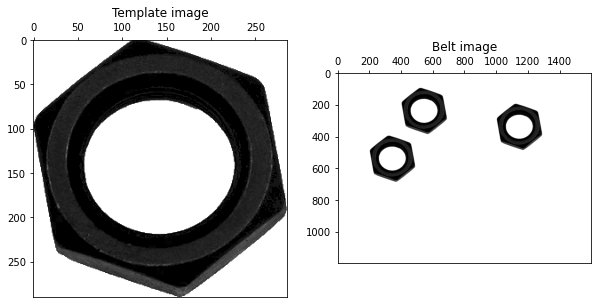

In [90]:
template_im = cv.imread(r'./resources/template.png', cv.IMREAD_GRAYSCALE) # prefix 'r' treats as raw text to the location
belt_im = cv.imread(r'./resources/belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1, 2, figsize=(10,10))

ax[0].imshow(template_im, cmap='gray') # showing image using gray color mapping
ax[0].xaxis.tick_top() # bring the x axis to top
ax[0].set_title("Template image")
ax[1].imshow(belt_im, cmap='gray')
ax[1].xaxis.tick_top()
ax[1].set_title("Belt image")
plt.show()

## Part 1

#### Brief introduction about thresholding

1. **Simple thresholding**  - *set a same threshold value to the every pixel... If the pixel is less than the threshold it is set as zero. Otherwise set to max value.  __cv.threshold("image in gray scale", "Threshold Value", " maximum value which is assigned to pixel values exceeding the threshold", "Type of thresholding")__... These types are,*

- cv.THRESH_BINARY --> {`max value` for pixels that are greater than threshold and `zero` for others}
- cv.THRESH_BINARY_INV --> {inverse of binary.........}
- cv.THRESH_TRUNC --> {`threshold value` for pixels that are greater than threshold and `original pixel values` for others}
- cv.THRESH_TOZERO --> {`original pixel values` for pixels that are greater than threshold and `zero` for others}
- cv.THRESH_TOZERO_INV --> {inverse of TOZERO.........}

[visualization](https://docs.opencv.org/master/threshold.jpg)

2. **Adaptive Thresholding** - *In the previous section, we used one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel __based on a small region around it__. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination. Thre are two addaptive methods*

- cv.ADAPTIVE_THRESH_MEAN_C --> The threshold value is the mean of the neighbourhood area minus the constant C.
- cv.ADAPTIVE_THRESH_GAUSSIAN_C --> The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C

The blockSize determines the size of the neighbourhood area and C is a constant that is subtracted from the mean or weighted sum of the neighbourhood pixels. __cv.adaptiveThreshold("source image", "maxValue", "adaptiveMethod", "thresholdType", "blockSize", "C")__

3. **Otsu's Binarization** - *Instead of just using threshold value as global thresholding it uses optimal threshold value by looking histogram (If histogram has two main peaks the best threshold is the middle value of two peaks). cv.threshold uses extra flag named as  cv.THRESH_OTSU which choose arbitary threshold value and return it as first output... if the image is noisy we can add filltering brfore at *

### 1.1.1 Otsu’s thresholding

threshold value for template image :  138.0
threshold value for belt image :  138.0


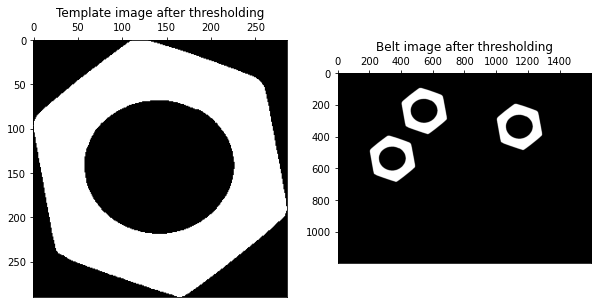

In [69]:
th_t, img_t = cv.threshold(template_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# printing the threshold value that defined from otsu binaraization
print("threshold value for template image : ", th_t)
print("threshold value for belt image : ", th_b)

fig, ax = plt. subplots(1, 2, figsize=(10,10))
ax[0].imshow(img_t, cmap='gray') # showing image using gray color mapping
ax[0].xaxis.tick_top() # bring the x axis to top
ax[0].set_title("Template image after thresholding")
ax[1].imshow(img_b, cmap='gray')
ax[1].xaxis.tick_top()
ax[1].set_title("Belt image after thresholding")
plt.show()

### 1.1.2 Morphological closing

*Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.*

1. **Erosion** - *The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero)........ So the thickness or size of the foreground object decreases or simply white region decreases in the image*

2. **Dilation** - *It is just opposite of erosion. Here, a pixel element is '1' if atleast one pixel under the kernel is '1'. So it increases the white region in the image or size of foreground object increases. *

**Closing** - *The closing operation dilates an image and then erodes the dilated image, using the same structuring element for both operations.Morphological closing is useful for **filling small holes from an image** while preserving the shape and size of the objects in the image.*

[]

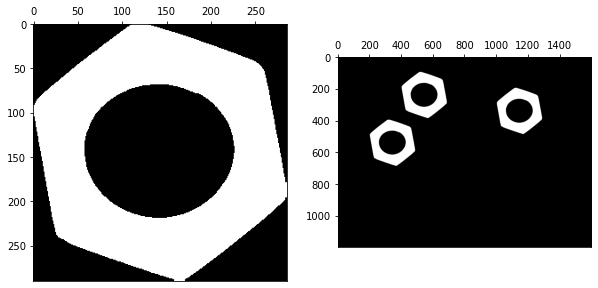

In [70]:
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

fig, ax = plt. subplots(1, 2, figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[0].xaxis.tick_top()
ax[1].imshow(closing_b, cmap='gray')
ax[1].xaxis.tick_top()
plt.plot()

### 1.1.3 Connected component analysis

*computes the connected components labeled image of boolean image and also produces a statistics output for each label. this function returns several outputs as follows*

1. **retval** - *return the no of connected componemts...the **background is also count** as a connected component...............*

- For the template image --> detected components = retval - 1 (background) = 2 - 1 = 1
- For the belt image --> detected components = retval - 1 (background) = 4 - 1 = 1

2. **label** - *matrix the size of the input image where each element has a value equal to its label......where 0 represents the background label*

3. **stats** - *matrix of the stats that the function calculates. It has a length equal to the number of labels and a width equal to the number of stats.......... Statistics output for each label, including the background label, see below for available statistics. Statistics are accessed via stats(label, COLUMN) where available columns are defined below.*

- cv2.CC_STAT_LEFT --> The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.

- cv2.CC_STAT_TOP --> The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.

- cv2.CC_STAT_WIDTH --> The horizontal size of the bounding box

- cv2.CC_STAT_HEIGHT --> The vertical size of the bounding box

- cv2.CC_STAT_AREA --> The total area (in pixels) of the connected component

*As you can see in the following result for stats, for the background(label = 0 : first row of stats matrix) both left most x coordinate and topmost y coordinate are equal to zero *

4. **centroids** - * matrix with the x and y locations of each centroid. The row in this matrix corresponds to the label number............(as you can see for the belt.png there are 4 centroids(first one for bacground and others for nuts on the belt))*


In [71]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

print("no of connected components for template image : ", retval_t)
print()
print("label matrix for template image : ")
print(labels_t)
print()
print("stats matrix for template image : ")
print(stats_t)
print()
print("centroid matrix for template image : ")
print(centroids_t)
print()
print()
print("no of connected components for belt image : ", retval_b)
print()
print("label matrix for belt image : ")
print(labels_b)
print()
print("stats matrix for belt image : ")
print(stats_b)
print()
print("centroid matrix for belt image : ")
print(centroids_b)

no of connected components for template image :  2

label matrix for template image : 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

stats matrix for template image : 
[[    0     0   286   290 42290]
 [    0     0   286   290 40650]]

centroid matrix for template image : 
[[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]


no of connected components for belt image :  4

label matrix for belt image : 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

stats matrix for belt image : 
[[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]

centroid matrix for belt image : 
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


### 1.1.4 Contour analysis

*Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.*

*for that image should be binary and object to be found should be white and background should be black.*

*cv.findContours("image", "Contour retrieval mode", "Contour Approximation Method")*

- Contour retrieval mode --> mode of the contour retrieval algorithm {(RETR_TREE - 	
retrieves all of the contours), (RETR_EXTERNAL - retrieves only the extreme outer contours)}

- Contour Approximation Method --> {( cv.CHAIN_APPROX_NONE - all the boundary points are stored. use more memory space), (cv.CHAIN_APPROX_SIMPLE - removes all redundant points and compresses the contour, thereby saving memory.)}

**outputs of the function**

- contours --> Detected contours. Each contour is stored as a vector of points
- hierarchy --> Optional output vector, containing information about the image topology.

In [72]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

## using second approximation method that described earlier find the contours for template image
contours_temp, hierarchy_temp = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)



### draw the contours

*cv.drawContours("image that you want to draw on", "All the input contours", "Parameter indicating a contour to draw. If it is negative, all the contours are drawn", "color", "thickness")*

For thickness, If it is negative, the contour interiors are drawn.

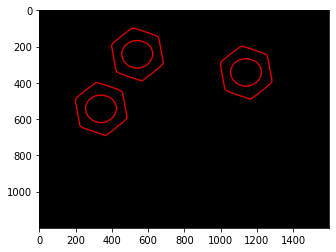

In [73]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8) # create a destination image to draw contours with dimentions of belt image.
conts = cv.drawContours(im_contours_belt, contours_b, -1, (255,0,0), 6).astype('uint8') #use red color 
plt.imshow(conts)

### 1.1.5 Count the number of matching hexagonal nuts in belt.png.

cv.matchShapes("First contour or grayscale image", "Second contour or grayscale image", "Comparison method", "Method-specific parameter")

*The lower the result, the better match it is*

In [74]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')

belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
    print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


## Part 2

### 1.2.1 Frame tracking through image moments.

In [75]:
ca = cv.contourArea(contours_b[1]) # give the area of contour
M = cv.moments(contours_b[1]) # give all moments of given contour
cx = int(M['m10']/M['m00']) # find the centroid coordinates
cy = int(M['m01']/M['m00'])

print(cx)
print(" ")
print(cy)

341
 
542


In [76]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

In [77]:
delta_x = 15
object_curr_frame = np.array([cx, cy, ca, count])

movement_of_cx = object_curr_frame[0] - object_prev_frame[0]

if movement_of_cx < delta_x :
    print("Hey Dear")

Hey Dear


## Part 3

### 1.3.1  1. Implement the function get_indexed_image

In [78]:
def get_indexed_image(im):
    th_im, img_im = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU) # otsu binarization
    kernel = np.ones((3,3), dtype=np.uint8)
    closing_im = cv.morphologyEx(img_im, cv.MORPH_CLOSE, kernel) # closing to fill holes
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_im) # connected component analysis


    return retval, labels, stats, centroids

get_indexed_image(belt_im)

(4,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[      0,       0,    1600,    1200, 1798161],
        [    400,     100,     286,     290,   40613],
        [   1000,     200,     286,     290,   40613],
        [    200,     400,     286,     290,   40613]], dtype=int32),
 array([[ 807.85728475,  614.56805258],
        [ 542.82567158,  243.78479797],
        [1142.82567158,  343.78479797],
        [ 342.82567158,  543.78479797]]))

### 1.3.2  2. Implement the function is_new, which checks the dissimilarity between 2 vectors. 

In [79]:
def is_new(a, b, delta, i):
    retVal = True
    for count_a in range(a.shape[0]):
        cnt = 0
        for count_i in range(i.shape[0]):
            # check the similarity of corresponding coloumn value of a and b
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) < delta[i[count_i]]: 
                cnt += 1  # check all values are equal or not
        if cnt == i.shape[0]: # if all values of each row of a is equal to b . it means current nut is equal to previously detected nut
            retVal = False

    return retVal # return True if the nut is new to the belt , False for otherwise

In [80]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
print (a[1]-b)
print(i.shape)

is_new(a, b, delta, i)
#assert is_new(a, b, delta, i) == False, " Check the function "

[10.  0.  0. -2.]
(1,)


False

### 1.3.3  3. write the function prev_index to find the index of a particular nut in the previous frame. 

In [81]:
def prev_index(a, b, delta, i):
    
    index = -1
    
    for count_a in range(a.shape[0]):
        cnt = 0
        for count_i in range(i.shape[0]):
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) < delta[i[count_i]]:  # Check whether nut is detected previously
                cnt += 1
        if cnt == i.shape[0]: # if it is detected in early frame return the index no of detected frame
            index = count_a

        

    return index

In [82]:
# check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

prev_index(a,b,delta,i)
#assert prev_index(a,b,delta,i) == 1, " Check the function "

2

In [83]:
# function to find contours easily

def find_contours(img):
    retval, labels, stats, centroids = get_indexed_image(img)
    label = 1 # remember that the label of the background is 0
    belt = ((labels >= label)*255).astype('uint8')
    belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    return belt_cont


In [84]:
cap = cv.VideoCapture('./resources/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # convert the frame to grayscale
    cv.imshow("frame", grey) # show the frame in grayscale
    if cv.waitKey(1) == ord('q'):
        break

    cv.namedWindow("IMAGE", cv.WINDOW_AUTOSIZE) # create a window for displaying images.

    contours = find_contours(grey) # find the contour vector of each grayscale frame
    im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8) # create a black background to display detected contours
    conts = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 3).astype('uint8') # draw the detected contours....

    cv.imshow("IMAGE", conts)
    

cap.release()
cv.destroyAllWindows()

### 1.5 Object detection and tracking

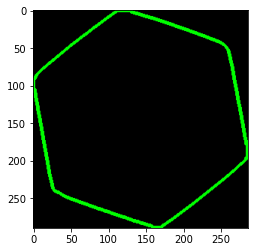

In [85]:
# Visualizing contour of template nut
cont_temp = find_contours(template_im)
im_contours_temp = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_temp, cont_temp, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

In [89]:
video = np.array([])   # initialize a vector to store the details (cx,cy,ca,count) of detected nuts       
# define delta and i arrays   
i = np.array([0])           
delta = np.array([30])  

frame_number = 0                    
                


cap = cv.VideoCapture('./resources/conveyor_with_rotation.mp4') # give the correct path here
created_video = cv.VideoWriter('./created_video/created_video_180564F.mp4', -1 , 30.0, (1920,1080))
while cap.isOpened():
    ret, frame = cap.read() # read the captured frame
    frame_number += 1  
    annotation_frameNo = ''   # initialize a text to store frame no       
    space = 0


    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    contours = find_contours(grey) # find the contour vector of each grayscale frame
    im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8) # create a black background to display detected contours
    
    
    for  cont in contours: # check the each contour in detected contours of each frame
        annotation = "" # initialize the text for annotation
        
        # create moments of each contour
        ca = cv.contourArea(cont)
        M = cv.moments(cont)
        if M['m00']==0:
            continue
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        count = 1 #number of contours
        object_curr_frame = np.array([cx, cy, ca, count]) # update the details about current detected frame

        # check the matching of detected contour with template contour(threshold value is set by after experiments)
        if cv.matchShapes(cont_temp[0], cont, cv.CONTOURS_MATCH_I1, 0.0) < 0.0002:

            # if this is the first frame , it will add to the vector
            if video.shape[0] == 0:       
                # remember to reshape the vector... otherwise you will get an error when running following functions
                video = (np.append(video, object_curr_frame)).reshape((1,4))
                no_of_nuts = video.shape[0]-1 # set the nut number

            # if it is not 1st frame check whether it is detected previously or not
            elif is_new(video, object_curr_frame, delta, i): 
                # if it is new concatenate it to the vector vedio
                video = np.concatenate((video, np.array([object_curr_frame])),axis=0)  
                no_of_nuts = video.shape[0]-1 # set the nut number

            else:
                # if it was detected get the nut number which is detected 
                no_of_nuts = prev_index(video, object_curr_frame, delta, i)  
                # update the vector with currently detected duplicate frame
                video[no_of_nuts] = object_curr_frame  
        
        else:
            continue


           
        font = cv.FONT_HERSHEY_COMPLEX
        # displaying text for each object
        annotation += "Object "+ str(no_of_nuts + 1)+ ": "+ str(video[no_of_nuts,0])+  ", "+ str(video[no_of_nuts,1])+ ", "+ str(video[no_of_nuts,2])

        cv.putText(im_contours_belt,str(no_of_nuts + 1), (cx,cy), font, 2,(255,255,255), 1, cv.LINE_AA)
        cv.putText(im_contours_belt, annotation, (100, 900-space), font, 1.0, (255,0,255), 1, cv.LINE_AA)
        space += 40

    # displayuing other details
    annotation_frameNo += "Frame No: " + str(frame_number)   
    cv.putText(im_contours_belt, "INDEX NO: 180564F ", (100, 100), font, 1.0, (255,255,255), 1, cv.LINE_AA)
    cv.putText(im_contours_belt, annotation_frameNo, (100, 900-space), font, 1.0, (0,255,0), 1, cv.LINE_AA)

    conts = cv.drawContours(im_contours_belt, contours, -1, (255,0,0), 6).astype('uint8')                              
    cv.namedWindow("frame", cv.WINDOW_NORMAL)    
    cv.imshow("frame",conts)

    created_video.write(conts)                                                                                            
                                                                                                
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
created_video.release()
cv.destroyAllWindows()




Can't receive frame (stream end?). Exiting ...
